In [30]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
import pylab as plt
import json
import pycrs
import seaborn as sns

from shapely.geometry import Point
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import GOSTnet as gn
from GOSTnet import calculate_OD
from pandana.loaders import osm;

from osgeo import gdal, gdalconst, gdal_array
from rasterstats import point_query, zonal_stats
from make_fishnet import make_fishnet

In [2]:
boundary_GDF = ox.gdf_from_place('Kampala',which_result=2)
boundary_GDF
boundary_poly = boundary_GDF.loc[0,'geometry']    # boundary as shapely polygon

In [3]:
pop_raster = rasterio.open('data/kampala_pop_2.tiff')
coords = (pop_raster.bounds[1], pop_raster.bounds[0], pop_raster.bounds[3], pop_raster.bounds[2])

In [4]:
path = 'data'
tif_10_proj_path = os.path.join(path, '10yr_Kampala_proj.tif')
tif_50_proj_path = os.path.join(path, '50yr_Kampala_proj.tif')
tif_100_proj_path = os.path.join(path, '100yr_Kampala_proj.tif')

In [94]:
raster = rasterio.open(tif_50_proj_path)

In [100]:
grid_clipped = gpd.sjoin(grid,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [103]:
Gk = ox.graph_from_place('Kampala', which_result=2)

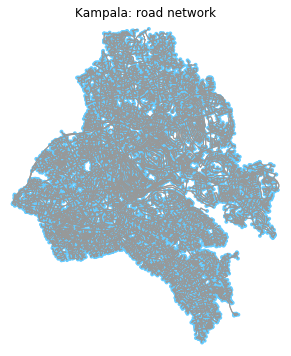

In [120]:
f,ax = ox.plot_graph(Gk,show=False,close=False)
#boundary_GDF.plot(alpha = 0.9,ax=ax)
#show(raster, ax = ax)

#grid_clipped.plot(ax=ax,alpha=0.5)
#POIs_health.plot(ax=ax,color='r')

plt.title('Kampala: road network');

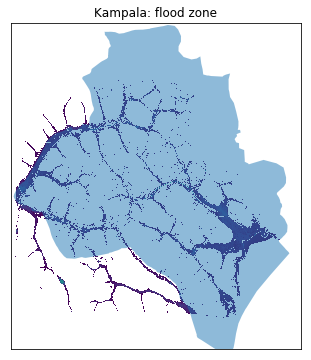

In [121]:
ax = boundary_GDF.plot(alpha = 0.5, figsize=[6,6])
show(raster, ax = ax)

#grid_clipped.plot(ax=ax,alpha=0.5)
#POIs_health.plot(ax=ax,color='r')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.title('Kampala: flood zone');

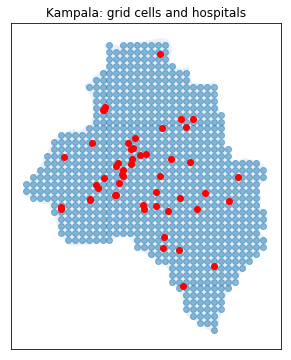

In [123]:
ax = boundary_GDF.plot(alpha = 0.1, figsize=[6,6])
#show(raster, ax = ax)

grid_clipped.plot(ax=ax,alpha=0.5)
POIs_health.plot(ax=ax,color='r')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.title('Kampala: grid cells and hospitals');

#### 3. Sample rasters for flood depth

In [37]:
# Create graph
G = ox.graph_from_polygon(boundary_poly, network_type = 'walk')

In [6]:
from shapely.geometry import Point
from shapely.geometry import LineString

node_dict = {}

G2 = G.copy()

for u, data in G2.nodes(data = True):
    node_dict[u] = Point(data['x'],data['y'])
        
for u, v, data in G2.edges(data = True):
    
    if 'Wkt' not in data.keys():
        strt = node_dict[u]
        fini = node_dict[v]
        data['Wkt'] = LineString([strt, fini])
    
    if 'geometry' in data.keys():
        data['Wkt'] = data['geometry']
        data.pop('geometry')

In [7]:
importlib.reload(gn)
G3 = gn.salt_long_lines(G2,
                       source = 'epsg:4326',
                      target = 'epsg:32636',
                      thresh = 50,
                      factor = 1)

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Identified 12152 unique edge(s) longer than 50. 
Beginning new node creation...
80088 new edges added and 23833 removed to bring total edges to 87881
27892 new nodes added to bring total nodes to 41590


In [8]:
G3 = gn.sample_raster(G3, tif_10_proj_path, property_name = 'flood_depth_10_yr')
G3 = gn.sample_raster(G3, tif_50_proj_path, property_name = 'flood_depth_50_yr')
G3 = gn.sample_raster(G3, tif_100_proj_path, property_name = 'flood_depth_100_yr')

#### 4. Create the degraded road networks

In [9]:
node_gdf = gn.node_gdf_from_graph(G3)
edge_gdf = gn.edge_gdf_from_graph(G3)

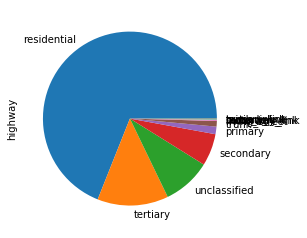

In [10]:
edge_gdf.highway[:5000].value_counts().plot(kind='pie')

In [11]:
speed_dict = {  'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':25,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

speed_dict_flooded = { 'residential': 19, 'primary': 36, 'primary_link':31.5, 'motorway':40.5, 'motorway_link': 36, 'trunk': 36, 'trunk_link':31.5, 'secondary': 28.5, 'secondary_link':22, 'tertiary':22, 'tertiary_link': 22, 'unclassified':19, 'road':19, 'crossing':19, 'living_street':19 }

In [38]:
#G3 = gn.convert_network_to_time(G3, distance_tag = 'length', speed_dict = speed_dict)
G3 = gn.convert_network_to_time(G3, graph_type='walk',
                                distance_tag = 'length', 
                                walk_speed=4.5,speed_dict = speed_dict)

In [42]:
my_flood_depth = 0.15
fail_value = 999999999999999

print("10 year:")
G_flood10 = gn.disrupt_network(G3.copy(), 'flood_depth_10_yr', my_flood_depth, fail_value)

print()
print("50 year:")
G_flood50 = gn.disrupt_network(G3.copy(), 'flood_depth_50_yr', my_flood_depth, fail_value)

print()
print("100 year:")
G_flood100 = gn.disrupt_network(G3.copy(), 'flood_depth_100_yr', my_flood_depth, fail_value)


10 year:
nodes disrupted: 919
edges disrupted: 2684

50 year:
nodes disrupted: 1236
edges disrupted: 3480

100 year:
nodes disrupted: 1377
edges disrupted: 3831


In [14]:
n_nodes = node_gdf.shape[0]
n_edges = edge_gdf.shape[0]
print("Threshold {} meters:".format(my_flood_depth))
print("10-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (919/n_nodes * 100, 2684/n_edges * 100))
print("50-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (1236/n_nodes * 100, 3480/n_edges * 100))
print("100-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (1377/n_nodes * 100, 3831/n_edges * 100))

Threshold 0.15 meters:
10-year flood disrupts 2.21 % of nodes and 3.05 % of edges
50-year flood disrupts 2.97 % of nodes and 3.96 % of edges
100-year flood disrupts 3.31 % of nodes and 4.36 % of edges


#### 6. Get origin points
* fishnet of the city
* sample of 307 firms from the employment survey

In [408]:
make_fishnet('grid_KM.shp',coords[1], coords[3], coords[0], coords[2],500,500) # takes xmin, xmax, ymin, ymax

In [15]:
grid=gpd.read_file('grid_KM.shp')

#### 7. Get destinations (POIs and employment density)

In [16]:
# Hospitals

In [17]:
bbox = pop_raster.bounds

amenities_hospital = ['hospital']
amenities_hospital = ['hospital']
POIs_health = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(amenities_hospital)))

POIs_health = POIs_health[['amenity','name','lat','lon']]
POIs_health = gpd.GeoDataFrame(POIs_health)
POIs_health['geometry'] = (list(zip(POIs_health.lon,POIs_health.lat)))
POIs_health['geometry'] = POIs_health.geometry.apply(lambda x: Point(x))

POIs_health = gpd.sjoin(POIs_health,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [415]:
# Employment density points

In [416]:
employment_points = gpd.read_file('data/jobdensity_kampala_points.shp')
employment_points['percent_jobs'] = employment_points.density/ employment_points.density.sum() * 100

print("There are {} grid cells for the employment density data. Mean percent of total jobs in a grid cell is {:.3f} and largest is {:.2f}".format(
    employment_points.shape[0], employment_points.percent_jobs.mean(), employment_points.percent_jobs.max()))

There are 6228 grid cells for the employment density data. Mean percent of total jobs in a grid cell is 0.016 and largest is 2.33


#### 9. Snap Os and Ds to graph

In [24]:
grid['centroid'] = grid.centroid
grid.set_geometry('geometry',inplace=True)

In [23]:
grid['geometry_copy'] = grid['geometry']
grid['geometry'] = grid['centroid']

In [43]:
# Origins
#ES_points = gn.pandana_snap(G3, grid)
grid = gn.pandana_snap(G3, grid)

# Destinations

POIs_health = gn.pandana_snap(G3, POIs_health)


/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1572: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1574: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [44]:
#list_of_nearest_nodes_ES = list(ES_points_nn.NN)
list_of_nearest_nodes_grid = list(grid.NN)
#list_of_nearest_nodes_POIs_biz = list(POIs_biz_nn.NN)
list_of_nearest_nodes_hospitals = list(POIs_health.NN)

## ANALYSIS

#### 10. Firm connectivity: travel time between ES points

In [45]:
baseline_OD_firms = calculate_OD(G3, list(ES_points_nn.NN), list(ES_points_nn.NN), fail_value, weight='time')

NameError: name 'ES_points_nn' is not defined

In [473]:
flood_OD_firms_10yr = calculate_OD(G_flood10, list(ES_points_nn.NN), list(ES_points_nn.NN), fail_value, weight='time')
flood_OD_firms_50yr = calculate_OD(G_flood50, list(ES_points_nn.NN), list(ES_points_nn.NN), fail_value, weight='time')
flood_OD_firms_100yr = calculate_OD(G_flood100, list(ES_points_nn.NN), list(ES_points_nn.NN), fail_value, weight='time')

In [474]:
travel_times_base = baseline_OD_firms[baseline_OD_firms < fail_value] / 60
travel_times_10 = flood_OD_firms_10yr[flood_OD_firms_10yr < fail_value] / 60
travel_times_50 = flood_OD_firms_50yr[flood_OD_firms_50yr < fail_value] / 60
travel_times_100 = flood_OD_firms_100yr[flood_OD_firms_100yr < fail_value] / 60

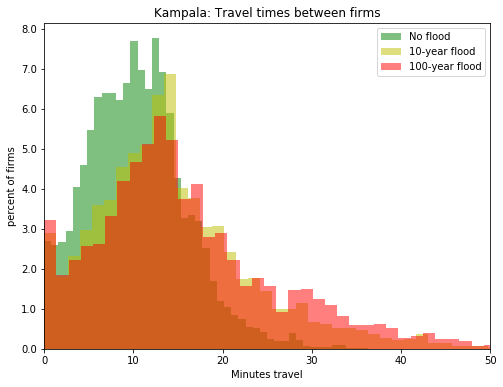

In [475]:
# Histogram of post-flood travel times between firms
bins = 50

fig,ax = plt.subplots(figsize=[8,6])
ax.hist(travel_times_base,color='g',alpha=0.5,density=True,bins=bins)
ax.hist(travel_times_10,color='y',alpha=0.5,density=True,bins=bins)
#ax.hist(travel_times_50,color='',alpha=0.5,density=True,bins=100)
ax.hist(travel_times_100,color='r',alpha=0.5,density=True,bins=bins)
plt.title('Kampala: Travel times between firms')
plt.ylabel('percent of firms')
plt.legend(['No flood','10-year flood','100-year flood'])
plt.xlabel('Minutes travel');

plt.xlim(0,50)

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

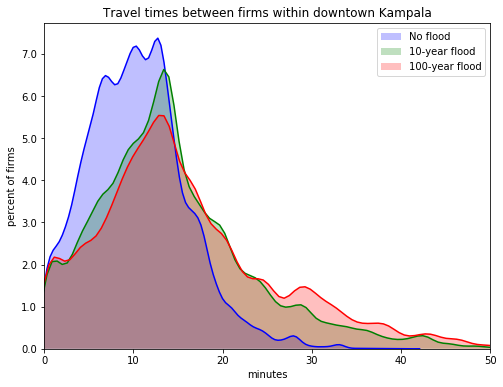

In [481]:
fig,ax = plt.subplots(figsize=[8,6])

sns.kdeplot(travel_times_base,ax = ax, color = 'b', shade=True)
sns.kdeplot(travel_times_10, ax=ax, color='g',shade=True)
#sns.kdeplot(travel_times_50, ax=ax, color='y',shade=True)
sns.kdeplot(travel_times_100, ax=ax, color='r',shade=True)

ax.set_title('Travel times between firms within downtown Kampala')
plt.legend(['No flood','10-year flood','100-year flood'])
ax.set(xlabel="minutes", ylabel='percent of firms');
plt.xlim(0,50)

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [502]:
baseline_mean = travel_times_base.mean()
flood_10_mean = travel_times_10.mean()
flood_50_mean = travel_times_50.mean()
flood_100_mean = travel_times_100.mean()


In [488]:
change_df = pd.DataFrame({"mean times":[baseline_mean, flood_10_mean, flood_100_mean]},index=
                        ['no flood','10-year flood','100-year flood'])

In [489]:
change_df['percent difference'] = (change_df['mean times'] - change_df['mean times'][0]) / change_df['mean times'][0] * 100
change_df

,mean times,percent difference
no flood,10.437115,0.000000
10-year flood,14.493512,38.865115
100-year flood,15.888126,52.227175


In [520]:
baseline_OD_firms_DF = pd.DataFrame(baseline_OD_firms)
flood_OD_firms_10yr_df = pd.DataFrame(flood_OD_firms_10yr)
flood_OD_firms_50yr_df = pd.DataFrame(flood_OD_firms_50yr)
flood_OD_firms_100yr_df = pd.DataFrame(flood_OD_firms_100yr)

In [545]:
baseline_mean = baseline_OD_firms_DF.mean(axis=1)
flood_10yr_mean = flood_OD_firms_10yr_df[flood_OD_firms_10yr_df < 999999].mean(axis=1)
flood_50yr_mean = flood_OD_firms_50yr_df[flood_OD_firms_50yr_df < 999999].mean(axis=1)
flood_100yr_mean = flood_OD_firms_100yr_df[flood_OD_firms_100yr_df < 999999].mean(axis=1)


In [553]:
mean_times_by_firm = pd.DataFrame({'baseline_mean' : baseline_OD_firms_DF.mean(axis=1),
                                  'flood_10yr_mean' : flood_OD_firms_10yr_df[flood_OD_firms_10yr_df < 999999].mean(axis=1),
                                  'flood_50yr_mean' : flood_OD_firms_50yr_df[flood_OD_firms_50yr_df < 999999].mean(axis=1),
                                  'flood_100yr_mean' : flood_OD_firms_100yr_df[flood_OD_firms_100yr_df < 999999].mean(axis=1)})

In [561]:
def percent_change(changed, original):
    return (changed - original)/original * 100

mean_times_by_firm['diff_10'] = percent_change(mean_times_by_firm.flood_10yr_mean, mean_times_by_firm.baseline_mean)
mean_times_by_firm['diff_50'] = percent_change(mean_times_by_firm.flood_50yr_mean, mean_times_by_firm.baseline_mean)
mean_times_by_firm['diff_100'] = percent_change(mean_times_by_firm.flood_100yr_mean, mean_times_by_firm.baseline_mean)

In [562]:
mean_times_by_firm.head()

,baseline_mean,flood_10yr_mean,flood_50yr_mean,flood_100yr_mean,diff_10,diff_50,diff_100
0,481.679127,671.280928,718.558220,719.158229,39.362677,49.177778,49.302344
1,545.125071,742.586802,886.864223,876.421348,36.223198,62.690045,60.774361
2,456.421247,570.368127,605.317678,599.755004,24.965288,32.622590,31.403831
3,780.649822,1071.283783,1115.318640,1100.259248,37.229748,42.870543,40.941459
4,521.459608,749.548894,1032.744938,1030.379789,43.740547,98.048885,97.595321


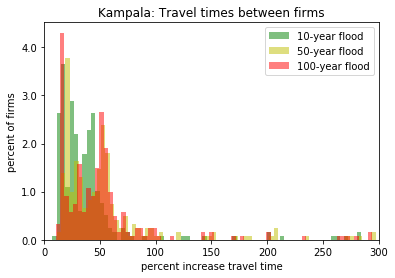

In [639]:
# Histogram of post-flood travel times between firms
bins = 100

fig,ax = plt.subplots(figsize=[6,4])
ax.hist(mean_times_by_firm.diff_10,color='g',alpha=0.5,density=True,bins=bins)
ax.hist(mean_times_by_firm.diff_50,color='y',alpha=0.5,density=True,bins=bins)
ax.hist(mean_times_by_firm.diff_100,color='r',alpha=0.5,density=True,bins=bins)
plt.title('Kampala: Travel times between firms')
plt.ylabel('percent of firms')
plt.legend(['10-year flood','50-year flood','100-year flood'])
plt.xlabel('percent increase travel time');

plt.xlim(0,300)

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

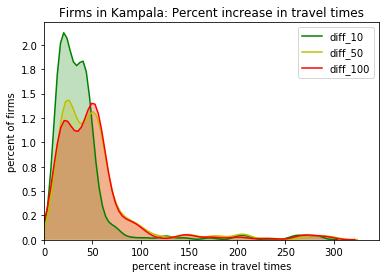

In [573]:
f,ax = plt.subplots(figsize=[6,4])

cols_to_show=['diff_10','diff_50','diff_100']
cols = ['g','y','r']

for n, column in enumerate(mean_times_by_firm[cols_to_show]):
    sns.kdeplot(mean_times_by_firm[column],shade=True,color=cols[n])
    
ax.set_title('Firms in Kampala: Percent increase in travel times')
plt.legend(cols_to_show)
#plt.legend(['No flood','50-year flood'])
plt.xlim(0)

ax.set(xlabel="percent increase in travel times", ylabel='percent of firms');

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [586]:
n_firms = mean_times_by_firm.shape[0]

sum(mean_times_by_firm.diff_10 < 25)


124

In [598]:
d25 = sum(mean_times_by_firm.diff_10 < 25)
d50 = sum(mean_times_by_firm.diff_10 < 50)
d75 = sum(mean_times_by_firm.diff_10 < 75)
d100 = sum(mean_times_by_firm.diff_10 < 100)
d300 = sum(mean_times_by_firm.diff_10 < 300)

In [ ]:
pd.DataFrame()

In [642]:
return_period = 'diff_50'

threshold1 = 25
threshold2 = 50
threshold3 = 100
threshold4 = 300

print("Number of firms:")
print("Travel times increase up to {}%: {}".format(threshold1, sum((mean_times_by_firm[return_period] > 0) & 
                                                    (mean_times_by_firm[return_period] < threshold1))))
print("Travel times increase up to {}%: {}".format(threshold2, sum((mean_times_by_firm[return_period] > threshold1) & 
                                                    (mean_times_by_firm[return_period] < threshold2))))
print("Travel times increase up to {}%: {}".format(threshold3, sum((mean_times_by_firm[return_period] > threshold2) & 
                                                    (mean_times_by_firm[return_period] < threshold3))))
print("Travel times increase more than {}%: {}".format(threshold3, sum((mean_times_by_firm[return_period] > threshold3) & 
                                                    (mean_times_by_firm[return_period] < threshold4))))

Number of firms:
Travel times increase up to 25%: 71
Travel times increase up to 50%: 87
Travel times increase up to 100%: 93
Travel times increase more than 100%: 21


In [643]:
mean_times_by_firm.to_csv('data/mean_times_by_firm.csv')

In [641]:
return_period = 'diff_50'

print("Percent of firms:")
print("Travel times increase up to {}%: {:.1f}".format(threshold1, sum((mean_times_by_firm[return_period] > 0) & 
                                                    (mean_times_by_firm[return_period] < threshold1))/ n_firms * 100))
print("Travel times increase up to {}%: {:.1f}".format(threshold2, sum((mean_times_by_firm[return_period] > threshold1) & 
                                                    (mean_times_by_firm[return_period] < threshold2))/ n_firms * 100))
print("Travel times increase up to {}%: {:.1f}".format(threshold3, sum((mean_times_by_firm[return_period] > threshold2) & 
                                                    (mean_times_by_firm[return_period] < threshold3))/ n_firms * 100))
print("Travel times increase more than {}%: {:.1f}".format(threshold3, sum((mean_times_by_firm[return_period] > threshold3) & 
                                                    (mean_times_by_firm[return_period] < threshold4))/ n_firms * 100))

Percent of firms:
Travel times increase up to 25%: 23.1
Travel times increase up to 50%: 28.3
Travel times increase up to 100%: 30.3
Travel times increase more than 100%: 6.8


In [619]:
pd.DataFrame(data={'Up to 25% increase':sum(mean_times_by_firm.diff_10 < 25),
              'Travel times increase 25% to 50%':sum((mean_times_by_firm.diff_10 > 25) & (mean_times_by_firm.diff_10 < 50)),
              'Travel times increase 50% to 75%':sum((mean_times_by_firm.diff_10 > 50) & (mean_times_by_firm.diff_10 < 75)),
              'Up to 100% increase':sum((mean_times_by_firm.diff_10 > 75) & (mean_times_by_firm.diff_10 < 100)),
               'More than 100% increase':sum((mean_times_by_firm.diff_10 > 100) & (mean_times_by_firm.diff_10 < 400)),
                  }, index=['Travel time change by number firms']).T

,Travel time change by number firms
Up to 25% increase,124
Travel times increase 25% to 50%,143
Travel times increase 50% to 75%,25
Up to 100% increase,2
More than 100% increase,13


In [618]:
pd.DataFrame(data={'Up to 25% increase':sum(mean_times_by_firm.diff_10 < 25) / n_firms * 100,
              'Travel times increase 25% to 50%':sum((mean_times_by_firm.diff_10 > 25) & (mean_times_by_firm.diff_10 < 50)) / n_firms * 100,
              'Travel times increase 50% to 75%':sum((mean_times_by_firm.diff_10 > 50) & (mean_times_by_firm.diff_10 < 75)) / n_firms * 100,
              'Up to 100% increase':sum((mean_times_by_firm.diff_10 > 75) & (mean_times_by_firm.diff_10 < 10)) / n_firms * 100,
               'More than 100% increase':sum((mean_times_by_firm.diff_10 > 100) & (mean_times_by_firm.diff_10 < 400)) / n_firms * 100,
                  }, index=['Travel time change by percent firms']).T

,Travel time change by percent firms
Up to 25% increase,40.390879
Travel times increase 25% to 50%,46.579805
Travel times increase 50% to 75%,8.143322
Up to 100% increase,0.000000
More than 100% increase,4.234528


In [ ]:
print("Travel times between firms in the enterprise survey (flood depth threshold: 10 cm)")
print()
print("Pre-flood: mean travel time {:.2f} minutes".format(PRE_travel_times.mean()))
print("Post-flood: mean travel time {:.2f} minutes".format(POST_travel_times.mean()))

print("Mean journey time increases by {:.1f}%".format((POST_travel_times.mean()-PRE_travel_times.mean()
                                                     )/PRE_travel_times.mean()*100))

In [51]:
print(1)

1


#### 10. Travel times grid to hospitals

In [46]:
baseline_OD_hosp = calculate_OD(G3, list(grid.NN), list(POIs_health.NN), fail_value, weight='time')

In [47]:
flood_OD_hosp_access_10yr = calculate_OD(G_flood10, list(grid.NN), list(POIs_health.NN), fail_value, weight='time')
flood_OD_hosp_access_50yr = calculate_OD(G_flood50, list(grid.NN), list(POIs_health.NN), fail_value, weight='time')
flood_OD_hosp_access_100yr = calculate_OD(G_flood100, list(grid.NN), list(POIs_health.NN), fail_value, weight='time')

In [70]:
baseline_df_hosp = pd.DataFrame(baseline_OD_hosp/60)
flood_df_hosp_10 = pd.DataFrame(flood_OD_hosp_access_10yr/60)
flood_df_hosp_50 = pd.DataFrame(flood_OD_hosp_access_50yr/60)
flood_df_hosp_100 = pd.DataFrame(flood_OD_hosp_access_100yr/60)

In [87]:
flood_df_hosp_10[flood_df_hosp_10 > 1000] = np.nan
flood_df_hosp_50[flood_df_hosp_50 > 1000] = np.nan
flood_df_hosp_100[flood_df_hosp_100 > 1000] = np.nan

In [89]:
time_to_nearest_hospital = pd.DataFrame({"Baseline":baseline_df_hosp.min(axis = 1),
              "Flood_10":flood_df_hosp_10.min(axis=1),
              "Flood_50":flood_df_hosp_50.min(axis=1),
              "Flood_100":flood_df_hosp_100.min(axis=1)})

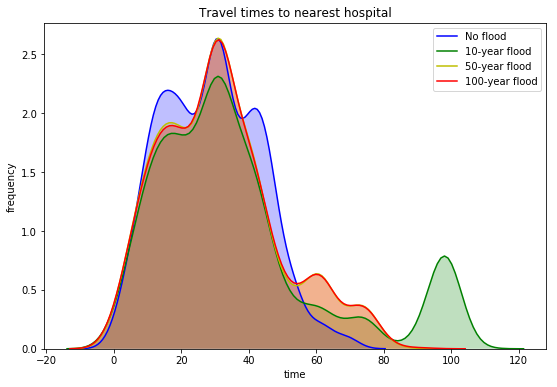

In [92]:
f,ax = plt.subplots(figsize=[9,6])
cols = ['b','g','y','r']

for n, column in enumerate(time_to_nearest_hospital.columns):
    sns.kdeplot(time_to_nearest_hospital[column],shade=True,color=cols[n])

ax.set_title('Travel times to nearest hospital')
plt.legend(['No flood','10-year flood','50-year flood','100-year flood'])
#ax.set_yticklabels([])
ax.set(xlabel="time", ylabel='frequency');

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

/anaconda3/envs/geo5/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/envs/geo5/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/envs/geo5/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/envs/geo5/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'de

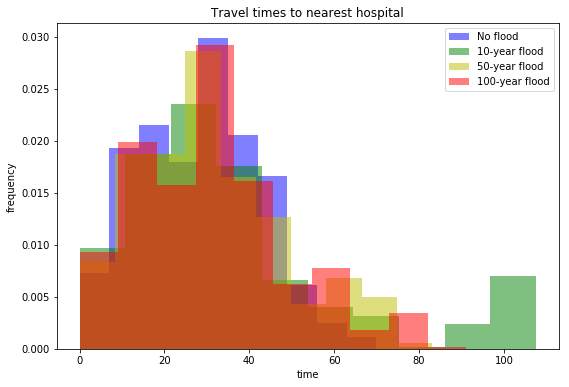

In [91]:
f,ax = plt.subplots(figsize=[9,6])
cols = ['b','g','y','r']

for n, column in enumerate(time_to_nearest_hospital):
    plt.hist(time_to_nearest_hospital[column],color=cols[n],alpha=0.5,normed=True)

ax.set_title('Travel times to nearest hospital')
plt.legend(['No flood','10-year flood','50-year flood','100-year flood'])
#ax.set_yticklabels([])
ax.set(xlabel="time", ylabel='frequency');

#### 11. Firms travel to business amenities

In [161]:
baseline_OD_biz_df = pd.DataFrame(
    calculate_OD(G3, list(ES_points.NN), list(POIs_biz.NN), fail_value, weight='time'))

In [163]:
flood_OD_biz_access_10yr_df = pd.DataFrame(
        calculate_OD(G_flood10, list(ES_points.NN), list(POIs_biz.NN), fail_value, weight='time'))

flood_OD_biz_access_50yr_df = pd.DataFrame(
        calculate_OD(G_flood50, list(ES_points.NN), list(POIs_biz.NN), fail_value, weight='time'))

flood_OD_biz_access_100yr_df = pd.DataFrame(
        calculate_OD(G_flood100, list(ES_points.NN), list(POIs_biz.NN), fail_value, weight='time'))

In [187]:
minutes = 15
threshold = minutes * 60       # Set a threshold (minutes * 60)

In [188]:
#baseline_n_reachable = baseline_OD_bizaccess_df[baseline_OD_bizaccess_df < threshold].count(axis=1)
#flood_10_n_reachable = flood_OD_bizaccess_10yr_df[flood_OD_bizaccess_10yr_df < threshold].count(axis=1)
#flood_50_n_reachable = flood_OD_bizaccess_50yr_df[flood_OD_bizaccess_50yr_df < threshold].count(axis=1)
#flood_100_n_reachable = flood_OD_bizaccess_100yr_df[flood_OD_bizaccess_100yr_df < threshold].count(axis=1)

In [191]:
n_reachable = pd.DataFrame({'baseline_n_reachable': baseline_OD_biz_df[baseline_OD_biz_df < threshold].count(axis=1),
                           'flood_10_n_reachable': flood_OD_biz_access_10yr_df[flood_OD_biz_access_10yr_df < threshold].count(axis=1),
                           'flood_50_n_reachable': flood_OD_biz_access_50yr_df[flood_OD_biz_access_50yr_df < threshold].count(axis=1),
                           'flood_100_n_reachable': flood_OD_biz_access_100yr_df[flood_OD_biz_access_100yr_df < threshold].count(axis=1)})

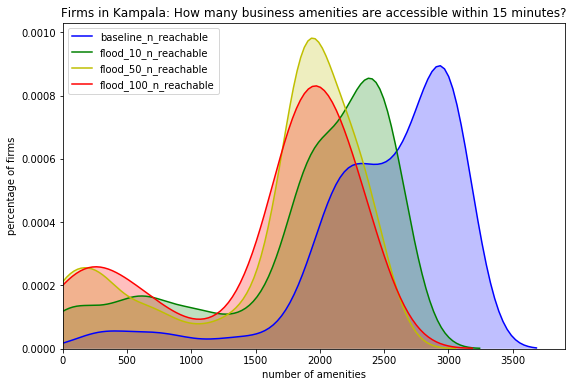

In [198]:
f,ax = plt.subplots(figsize=[9,6])

cols_to_show=['baseline_n_reachable','flood_10_n_reachable','flood_50_n_reachable','flood_100_n_reachable']
cols = ['b','g','y','r']

for n, column in enumerate(n_reachable[cols_to_show]):
    sns.kdeplot(n_reachable[column],shade=True,color=cols[n])
    
ax.set_title('Firms in Kampala: How many business amenities are accessible within {} minutes?'.format(minutes))
plt.legend(cols_to_show)
#plt.legend(['No flood','50-year flood'])
plt.xlim(0)
#ax.set_yticklabels([])
ax.set(xlabel="number of amenities", ylabel='percentage of firms');

#### 11. What proportion of jobs accessible within x minutes?

In [341]:
baseline_OD_jobs_df = pd.DataFrame(
    calculate_OD(G3, list(grid.NN), list(employment_points.NN), fail_value, weight='time'), index = list(grid.NN), columns = list(employment_points.NN)).T

In [342]:
flood_OD_jobs_10yr_df = pd.DataFrame(
        calculate_OD(G_flood10, list(grid.NN), list(employment_points.NN), fail_value, weight='time'), index = list(grid.NN), columns = list(employment_points.NN))

flood_OD_jobs_50yr_df = pd.DataFrame(
        calculate_OD(G_flood50, list(grid.NN), list(employment_points.NN), fail_value, weight='time'), index = list(grid.NN), columns = list(employment_points.NN))

flood_OD_jobs_100yr_df = pd.DataFrame(
        calculate_OD(G_flood100, list(grid.NN), list(employment_points.NN), fail_value, weight='time'), index = list(grid.NN), columns = list(employment_points.NN))

In [280]:
# STEPS
# get list of nodes reachable from each grid point
# get list of employment points for which NN is the nearest node
# sum the employment in those point
# that gives you number of jobs reachable from any grid square u

print("Grid cells: {}".format(grid.shape[0]))
print("Employment points: {}".format(employment_points.shape[0]))

print("OD matrix shape: {} rows, {} columns".format(baseline_OD_jobs_df.shape[0],baseline_OD_jobs_df.shape[1]))

Grid cells: 1512
Employment points: 6228
OD matrix shape: 6228 rows, 1512 columns


In [ ]:
def calculate_values_accessible(OD_matrix, gdf, field_to_sum, threshold):
    
    ### Calculate how many jobs (or other attributes) are accessible within a given journey time.
    # REQUIRES:     OD_matrix    -  a df where index gives the NN of each origin, columns give the NN of each destination, and values are journey time in seconds.
    #               gdf          -  a gdf with points and a nearest node field (NN)
    #               field_to_sum - the gdf column to sum
    # RETURNS:      list with the sum of accessible values for each origin point.
    
    OD = OD_matrix.copy()
    
    sum_accessible_list = []

    for col in OD.columns:
        reachable_nodes = list(OD[col][OD[col] < threshold].index) # list the reachable nodes

        reachable_nodes = list(OD[col][OD[col] < threshold].index) 
        sum_accessible = gdf[field_to_sum][gdf.NN.isin(reachable_nodes)].sum()
        sum_accessible_list.append(sum_accessible)
        
    return(sum_accessible_list)

In [327]:
minutes = 15
threshold = minutes * 60       # Set a threshold (minutes * 60)

In [333]:
baseline_jobs_accessible = calculate_values_accessible(baseline_OD_jobs_df, employment_points, 'percent_jobs', threshold)
flood_10_jobs_accessible = calculate_values_accessible(flood_OD_jobs_10yr_df, employment_points, 'percent_jobs', threshold)
flood_50_jobs_accessible = calculate_values_accessible(flood_OD_jobs_50yr_df, employment_points, 'percent_jobs', threshold)
flood_100_jobs_accessible = calculate_values_accessible(flood_OD_jobs_100yr_df, employment_points, 'percent_jobs', threshold)

In [337]:
flood_OD_jobs_10yr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,6218,6219,6220,6221,6222,6223,6224,6225,6226,6227
0,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,2743.242339,2.000000e+15
1,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,2743.242339,2.000000e+15
2,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,2743.242339,2.000000e+15
3,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,2743.242339,2.000000e+15
4,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,2743.242339,2.000000e+15


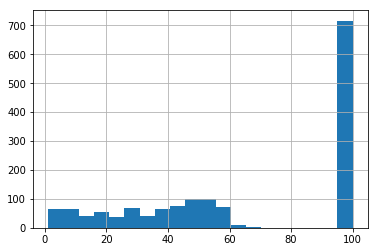

In [336]:
pd.Series(baseline_jobs_accessible).hist(bins = 20)

In [273]:
employment_points.percent_jobs[employment_points.NN.isin(list_of_reachable_nodes)].sum()

17.294893101150475

In [224]:
employment_points.head()

,Id,x_centroid,y_centroid,density,geometry,percent_jobs,x,y,NN
0,1,32.436709,0.021084,0.09,POINT (32.43670924673388 0.02108392351784156),0.001445,32.436709,0.021084,5508792311
1,2,32.441201,0.021084,2.74,POINT (32.44120082315448 0.02108392351784156),0.043996,32.441201,0.021084,5508792311
2,3,32.445692,0.021084,2.05,POINT (32.44569239957508 0.02108392351784156),0.032917,32.445692,0.021084,3892127977
3,4,32.427726,0.025606,0.28,POINT (32.42772609389268 0.02560577053669072),0.004496,32.427726,0.025606,5508792311
4,5,32.436709,0.025606,1.03,POINT (32.43670924673388 0.02560577053669072),0.016539,32.436709,0.025606,5508792311


In [221]:
baseline_OD_jobs_df.head(1)

,5508792311,5508792311,3892127977,5508792311,5508792311,5508792311,5508792311,3892127977,5508792311,5508792311,...,6216122215,6216122215,3889863642,3842552846_6830_22632,2163104626,2163104626,2163104626,2163104626,6229620127,579895174
6220689098,1770.025308,1770.025308,2511.018477,1770.025308,1770.025308,1770.025308,1770.025308,2511.018477,1770.025308,1770.025308,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,1709.038404,1642.015392


In [208]:
baseline_OD_jobs_df.index = list(grid.NN)
baseline_OD_jobs_df.columns = list(employment_points.NN)

In [201]:
minutes = 15
threshold = minutes * 60       # Set a threshold (minutes * 60)

In [211]:
jobs_reachable_baseline = pd.DataFrame({'baseline_jobs_reachable': baseline_OD_jobs_df[baseline_OD_jobs_df < threshold].sum(axis=1)})

In [202]:
jobs_reachable = pd.DataFrame({'baseline_jobs_reachable': baseline_OD_jobs_df[baseline_OD_jobs_df < threshold].sum(axis=1),
                           'flood_10_jobs_reachable': flood_OD_jobs_10yr_df[flood_OD_jobs_10yr_df < threshold].sum(axis=1),
                           'flood_50_jobs_reachable': flood_OD_jobs_50yr_df[flood_OD_jobs_50yr_df < threshold].sum(axis=1),
                           'flood_100_jobs_reachable': flood_OD_jobs_100yr_df[flood_OD_jobs_100yr_df < threshold].sum(axis=1)})

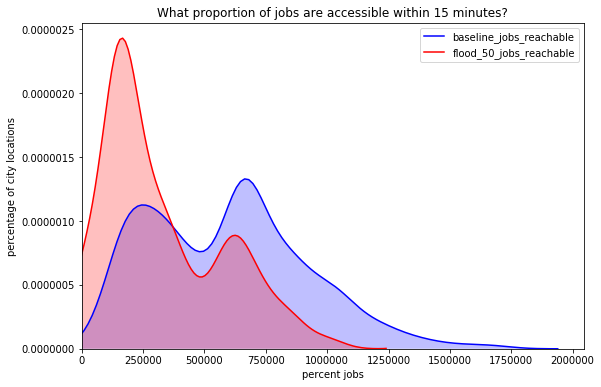

In [205]:
f,ax = plt.subplots(figsize=[9,6])

#cols_to_show=['baseline_jobs_reachable','flood_10_jobs_reachable','flood_50_jobs_reachable','flood_100_jobs_reachable']
#cols = ['b','g','y','r']

cols_to_show=['baseline_jobs_reachable','flood_50_jobs_reachable']
cols = ['b','r']

for n, column in enumerate(jobs_reachable[cols_to_show]):
    sns.kdeplot(jobs_reachable[column],shade=True,color=cols[n])
    
ax.set_title('What proportion of jobs are accessible within {} minutes?'.format(minutes))
plt.legend(cols_to_show)
#plt.legend(['No flood','50-year flood'])
plt.xlim(0)
#ax.set_yticklabels([])
ax.set(xlabel="percent jobs", ylabel='percentage of city locations');